
## **Домашняя работа 5: Бустинг и кластеризация**

### **Постановка задачи:**

В этой работы ваша задача подразделена на части:

*   В первой части вам предстоит реалищовать класс бустинга и сравнить его со встроенными классами популярных библиотек;
*   Во второй части вам предстоит применить алгоритмы кластеризации в задаче  разделения изображения на семантические компоненты;

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**

## **Часть 1: построение класса алгоритма бустинга**

**Количество баллов:** 7

Начнём с нужных библиотек и загрузки данных. Работать будем с датасетом из Kaggle и с синтетическим датасетом.

Данные c Kaggle связаны с телефонной рекламой португальского банковского учреждения. Цель классификации — спрогнозировать, подпишется ли клиент на срочный депозит (переменная y).

Всего в данных 20 признаков, ознакомиться с признаковым описанием можно [здесь](https://www.kaggle.com/code/sachinrajput17/subscription-prediction-for-bank-marketing-data).

Будем действовать из предположений, что датасет достаточно хорош, чтобы мы уже могли построить на нём базовую модель.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

In [2]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [3]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

age            job   marital            education  default housing loan  \
2135   44  self-employed  divorced  professional.course       no     yes   no   
2973   48       services    single          high.school       no     yes   no   
2556   47    blue-collar   married          high.school  unknown     yes   no   
5624   36         admin.    single    university.degree  unknown     yes   no   
970    45    blue-collar    single             basic.9y  unknown     yes   no   

        contact month day_of_week  ...  campaign  pdays  previous  \
2135   cellular   jun         thu  ...         1    999         0   
2973   cellular   apr         mon  ...         3    999         0   
2556  telephone   jun         mon  ...         3    999         0   
5624   cellular   may         wed  ...         1    999         0   
970    cellular   may         tue  ...         1    999         0   

         poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
2135  nonexistent         -1.7          94.055          -39.8      0.742   
2973  nonexistent         -1.8          93.075          -47.1      1.405   
2556  nonexistent          1.4          94.465          -41.8      4.961   
5624  nonexistent         -1.8          92.893          -46.2      1.334   
970   nonexistent         -1.8          92.893          -46.2      1.344   

      nr.employed  y  
2135       4991.6  1  
2973       5099.1  1  
2556       5228.1 -1  
5624       5099.1  1  
970        5099.1 -1  

[5 rows x 21 columns]

Разделим на train и test (random_state не меняем)

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

Генерируем синтетические данные (seed не меняем)

In [5]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [6]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''

    mask = np.random.choice([True, False], size=features.shape[0],
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps

    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)

    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid).reshape(steps, steps)
        values = (targets[mask] == 1).astype(np.float64)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')

    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()

    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

### **Задание 1. (4 балла) Реализуйте бустинг для задачи бинарной классификации**

Реализовывать класс буситнга необходимо согласно его теоретическому описанию. Вы начинаете с параметрами:

- `base_model_class=DecisionTreeRegressor` — базовая модель
- `base_model_params: dict={'max_features': 0.1}` — параметрмы базовой модели, рассчет максимального количества признаков полагаем как: `max(1, int(max_features * n_features_in_))`
- `n_estimators: int=10` — количество моделей
- `learning_rate: float=0.1` — скорость обучения
- `subsample: float=0.3` — доля данных, которая будет использоваться для подбора отдельных алгоритмов.
— `random_seed: int=228` — тут как всегда
– `custom_loss: list or tuple=None` — функция потерь
— `use_best_model: bool=False` — использовать ли при вызове predict и predict_proba лучшее с точки зрения валидационной выборки число деревьев в композиции
— `n_iter_early_stopping: int=None` — ранний критерий остановки

**Примечание:**

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже).

**Примечание 2:**

Нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

In [113]:
class Boosting:

    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1},
        n_estimators: int=10,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None
    ):

        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_early_stopping = n_iter_early_stopping

        # Место для нулевой модели
        self.initial_model_pred = None

        # Список для хранения весов при моделях
        self.gammas = []

        # Создаем список базовых моделей
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]

        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)


    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        """
        self.models[n_model].fit(X, y)


    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.
        """
        sigmoid_pred = 0.99 if y.mean() > 0 else 0.01
        self.initial_model_pred = np.log(sigmoid_pred/(1-sigmoid_pred))


    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (после сигмоиды)
        :param boudnaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        # Определеяем начальные лосс и оптимальную гамму
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 100)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss

        return optimal_gamma


    def fit(self, X, y, eval_set=None):
        """
        Функция для обучения всей модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """
        np.random.seed(self.random_seed)
        self._fit_initial_model(X, y)
        cur_train_ensemble_pred = np.full(y.shape, self.initial_model_pred)

        if eval_set is not None:
            cur_val_ensemble_pred = np.full(eval_set[1].shape, self.initial_model_pred)
            cur_val_loss = self.loss_fn(eval_set[1], cur_val_ensemble_pred)
            self.best_num_estimators = (0, cur_val_loss)

        for idx in range(self.n_estimators):
            bootstrap = np.random.choice(len(y), size=round(self.subsample*len(y)))
            X_cur, y_cur, pred_cur = X[bootstrap], y[bootstrap], cur_train_ensemble_pred[bootstrap]
            s_cur = -self.loss_derivative(y_cur, pred_cur)
            self._fit_new_model(X_cur, s_cur, idx)
            new_predicitions = self.models[idx].predict(X)
            new_gamma = self._find_optimal_gamma(y, cur_train_ensemble_pred, new_predicitions)

            self.gammas.append(new_gamma)
            cur_train_ensemble_pred += self.learning_rate * new_gamma * new_predicitions

            if eval_set is not None:
                cur_val_ensemble_pred += new_gamma * self.models[idx].predict(eval_set[0], eval_set[1])
                cur_val_loss = self.loss_fn(eval_set[1], cur_val_ensemble_pred)
                if cur_val_loss < self.best_num_estimators[1]:
                    self.best_num_estimators = (idx+1, cur_val_loss)
                elif self.n_iter_early_stopping is not None and \
                      idx + 1 - self.best_num_estimators[0] >= self.n_iter_early_stopping:
                    self.use_best_model = True
                    break

        n_estimators = self.best_num_estimators[0] if self.use_best_model \
                      else self.n_estimators
        feature_importances = np.zeros(X.shape[1])
        for idx in range(n_estimators):
            if hasattr(self.models[idx], 'feature_importances_'):
                feature_importances += self.gammas[idx] * self.models[idx].feature_importances_
            elif hasattr(self.models[idx], 'coef_'):
                coefs_abs = np.abs(self.models[idx].coef_)
                importance_equivalent = coefs_abs / np.sum(coefs_abs)
                feature_importances += self.gammas[idx] * importance_equivalent
        self._feature_importances = feature_importances / sum(self.gammas)


    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """
        return np.round(self.predict_proba(X))



    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """
        n_estimators = self.best_num_estimators[0] if self.use_best_model \
                      else self.n_estimators
        cur_pred = np.full(X.shape[0], self.initial_model_pred)

        for idx in range(n_estimators):
            cur_pred += self.gammas[idx] * self.models[idx].predict(X)

        return self.sigmoid(cur_pred)

    @property
    def feature_importances_(self):
        """
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса.
        """
        return self._feature_importances

## **Тест для вашей имплементации.**

Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!

In [114]:
%%time

boosting = Boosting()
boosting.fit(X_train_synthetic, y_train_synthetic)
# Без разницы, выдает эта строка классы или вероятности

preds = np.round(boosting.predict_proba(X_test_synthetic) > 0.5)

print(accuracy_score((y_test_synthetic == 1), preds))

0.9123
CPU times: user 3.27 s, sys: 3.02 ms, total: 3.28 s
Wall time: 3.29 s


In [116]:
%%time

boosting = Boosting()
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)

print(accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87)

True
CPU times: user 318 ms, sys: 0 ns, total: 318 ms
Wall time: 324 ms


### **Задание 2. (1.2 балла) Сравнение с базовыми моделями**

- Сравните результаты вашей имплементации бустинга, где в качестве базовых моделей используйте алгоритмы, перечисленные ниже. Сравнение проводите на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных. Данные берите из реальной задачи (bank_data).
- Ответьте на поставленные вопросы

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):

- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

In [118]:
results = {}

#### Решающее дерево

In [119]:
tree_boosting = Boosting(base_model_params={'max_features': 0.1, 'max_depth': 6})
tree_boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)

preds_train = tree_boosting.predict(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values)
preds_test = tree_boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values)

results['DecisionTree (depth=6)'] = {
    'train': accuracy_score((df_train.y.values == 1), preds_train),
    'test': accuracy_score((df_test.y.values == 1), preds_test)
}

#### Случайный лес

In [120]:
from sklearn.ensemble import RandomForestRegressor

In [121]:
forest_boosting = Boosting(base_model_class=RandomForestRegressor)
forest_boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)

preds_train = forest_boosting.predict(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values)
preds_test = forest_boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values)

results['RandomForest'] = {
    'train': accuracy_score((df_train.y.values == 1), preds_train),
    'test': accuracy_score((df_test.y.values == 1), preds_test)
}

#### Линейная регрессия

In [122]:
from sklearn.linear_model import LinearRegression

In [123]:
linear_boosting = Boosting(base_model_class=LinearRegression, base_model_params={})
linear_boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)

preds_train = linear_boosting.predict(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values)
preds_test = linear_boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values)

results['LinearRegression'] = {
    'train': accuracy_score((df_train.y.values == 1), preds_train),
    'test': accuracy_score((df_test.y.values == 1), preds_test)
}

#### Сравнение

In [124]:
pd.DataFrame(results).T

train      test
DecisionTree (depth=6)  0.835129  0.828664
RandomForest            0.918777  0.884159
LinearRegression        0.830954  0.822198

**Вопросы:**

1) Какая из моделей имеет оптимальное качество? С чем это связано?

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

4) Визуализируйте предсказания моделей только на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

**Ответ:**
1. RandomForest, так как из всех рассмотренных базовых моделей это единственный ансамбль, а смещение у ансамблей меньше, чем у одиночных моделей
2. В данном случае сильнее всего переобучился бустинг над RandomForest. Здась могла бы помочь ранняя остановка или обрезание до лучшей модели, так как удалось бы отследить момент, в который модель начинает переобучаться

3. Нет, бустинг над линейными регрессиями работает хуже. Вероятно, так происходит из-за того, что линейной модели не удается сойтись после константных предсказаний:

In [125]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
logreg.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, (df_train.y.values == 1))

preds_test = logreg.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values)

accuracy_score((df_test.y.values == 1), preds_test)

0.8550646551724138

4. На визуализациях бустинги отражают свойства саоих базовых моделей:
 - в случае с деревом признаковое пространство дробится на отдельные области, каждой из которых соответствует своё значение вероятности
 - в случае со случайным лесом ситуация похожа на дерево, но деление пространства значительно более дробное, что логично, так как в сумме мы обучили в 100 раз больше деревьев
 - в случае с линейной регрессией мы получили линию, разделяющую данные, которая похожа на разделяющую плоскость в случае линейных моделей классификации

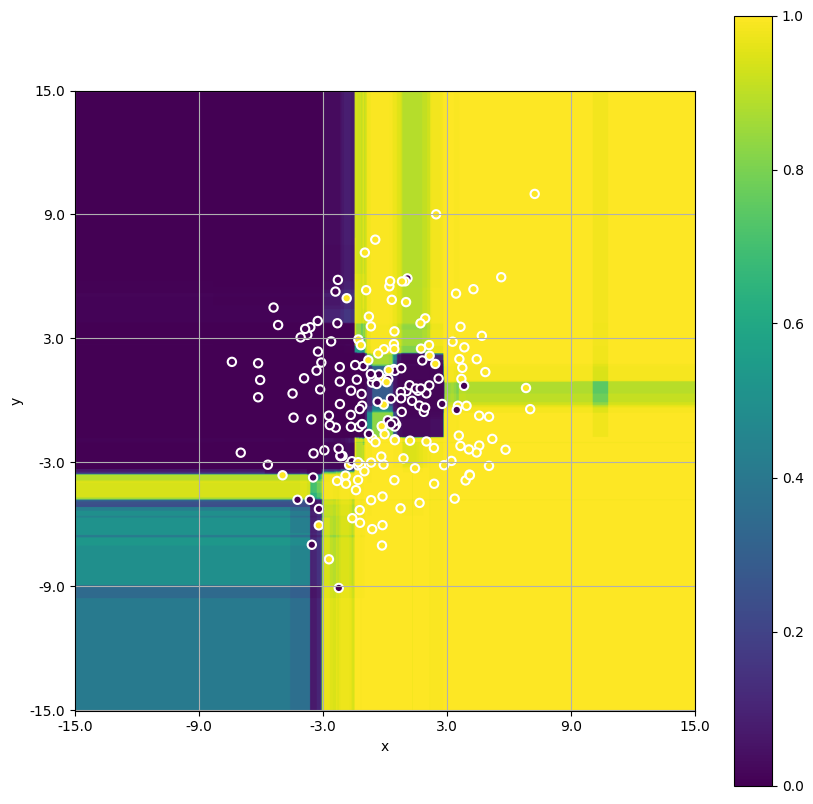

In [126]:
tree_boosting = Boosting(base_model_params={'max_features': 0.1, 'max_depth': 6})
tree_boosting.fit(X_train_synthetic, y_train_synthetic)
plot_predicts(tree_boosting, X_test_synthetic, y_test_synthetic)

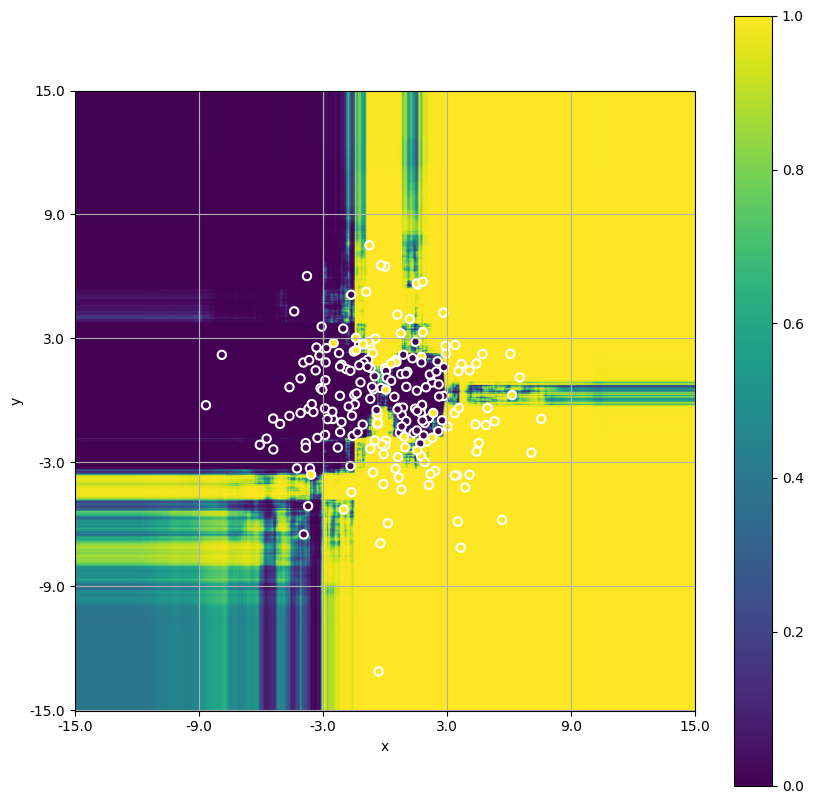

In [127]:
forest_boosting = Boosting(base_model_class=RandomForestRegressor)
forest_boosting.fit(X_train_synthetic, y_train_synthetic)
plot_predicts(forest_boosting, X_test_synthetic, y_test_synthetic)

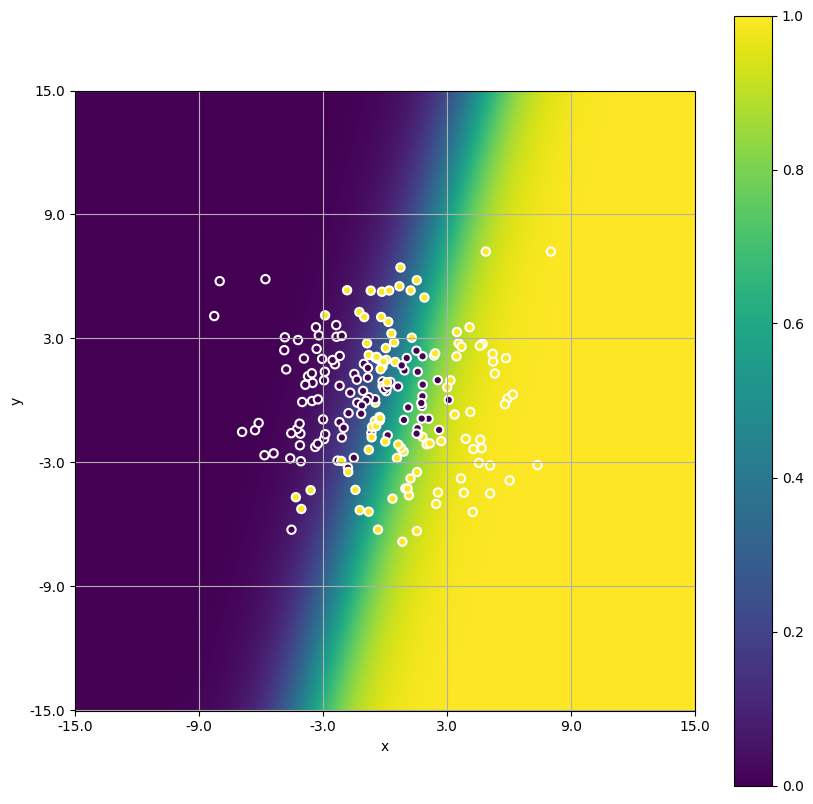

In [128]:
linear_boosting = Boosting(base_model_class=LinearRegression, base_model_params={})
linear_boosting.fit(X_train_synthetic, y_train_synthetic)
plot_predicts(linear_boosting, X_test_synthetic, y_test_synthetic)

### **Задание 3. (0.8 балла) Сравнение с бустингами**

- Сравните на реальных данных данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией.
- Укажите, получилось ли у вас победить библиотечные реализации на тестовых данных?

**Примечание:**

Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов.


In [129]:
%%capture
!pip install lightgbm -q
!pip install optuna -q

In [130]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import optuna

In [131]:
def objective_lgbm(trial):
    max_depth = trial.suggest_int("max_depth", 2, 40)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1)
    n_estimators = trial.suggest_int("n_estimators", 10, 500)

    score = cross_val_score(
        LGBMClassifier(
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators
        ),
        df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values,
        df_train.y.values == 1,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    ).mean()
    return score


study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2025-02-12 10:24:58,976] A new study created in memory with name: no-name-c0ae3634-cb59-41af-aa3e-8c26aa3f2ea2
[I 2025-02-12 10:25:03,002] Trial 0 finished with value: 0.8733838519933911 and parameters: {'max_depth': 39, 'learning_rate': 0.5875424790557221, 'n_estimators': 49}. Best is trial 0 with value: 0.8733838519933911.
[I 2025-02-12 10:25:03,375] Trial 1 finished with value: 0.8883355244713368 and parameters: {'max_depth': 32, 'learning_rate': 0.1443374143410362, 'n_estimators': 109}. Best is trial 1 with value: 0.8883355244713368.
[I 2025-02-12 10:25:03,755] Trial 2 finished with value: 0.8751349659352893 and parameters: {'max_depth': 24, 'learning_rate': 0.493153658292509, 'n_estimators': 121}. Best is trial 1 with value: 0.8883355244713368.
[I 2025-02-12 10:25:04,606] Trial 3 finished with value: 0.8733829265437997 and parameters: {'max_depth': 22, 'learning_rate': 0.6454035733120569, 'n_estimators': 295}. Best is trial 1 with value: 0.8883355244713368.
[I 2025-02-12 10:25:

In [132]:
def objective_custom(trial):
    max_depth = trial.suggest_int("max_depth", 2, 40)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1)
    n_estimators = trial.suggest_int("n_estimators", 10, 500)

    score = cross_val_score(
        Boosting(
            base_model_params={
                'max_depth': max_depth,
            },
            learning_rate=learning_rate,
            n_estimators=n_estimators
        ),
        df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values,
        df_train.y.values,
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    ).mean()
    return score


study_custom = optuna.create_study(direction="maximize")
study_custom.optimize(objective_lgbm, n_trials=30)

[I 2025-02-12 10:25:33,414] A new study created in memory with name: no-name-f49e2850-8a27-4fdd-a142-879aa74914d6
[I 2025-02-12 10:25:34,518] Trial 0 finished with value: 0.8807915860300662 and parameters: {'max_depth': 12, 'learning_rate': 0.19522175841711925, 'n_estimators': 225}. Best is trial 0 with value: 0.8807915860300662.
[I 2025-02-12 10:25:34,914] Trial 1 finished with value: 0.8785024048079828 and parameters: {'max_depth': 35, 'learning_rate': 0.37645137066036966, 'n_estimators': 120}. Best is trial 0 with value: 0.8807915860300662.
[I 2025-02-12 10:25:36,290] Trial 2 finished with value: 0.869073107795824 and parameters: {'max_depth': 9, 'learning_rate': 0.7320216779771294, 'n_estimators': 270}. Best is trial 0 with value: 0.8807915860300662.
[I 2025-02-12 10:25:39,141] Trial 3 finished with value: 0.86772576206691 and parameters: {'max_depth': 6, 'learning_rate': 0.9715441719326442, 'n_estimators': 321}. Best is trial 0 with value: 0.8807915860300662.
[I 2025-02-12 10:25:4

In [133]:
lgbm = LGBMClassifier(**study_lgbm.best_params)
lgbm.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, (df_train.y.values==1))
preds_test = lgbm.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values)
accuracy_score((df_test.y.values == 1), preds_test)

[LightGBM] [Info] Number of positive: 3738, number of negative: 3686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 7424, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503502 -> initscore=0.014009
[LightGBM] [Info] Start training from score 0.014009


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



0.8927801724137931

In [135]:
custom = Boosting(
    learning_rate=1,
    n_estimators=study_custom.best_params['n_estimators'],
    base_model_params={'max_depth': study_custom.best_params['max_depth']}
)
custom.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
preds_test = custom.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values)
accuracy_score((df_test.y.values == 1), preds_test)

0.8728448275862069

**Ваш ответ здесь**

Нет, победить библиотечную реализацию не удалось, но довольно близко

###**Задание 4. (1 балл) Капля теории**

Теоретически, мы могли бы построить бэггинг на логистических регрессиях. Оцените целесообразность такого подхода. В ответе укажите:

- Идею бэггинга и его свойства;
- Характеристики модели логистической регресии;
- Сопоставление и вывод.


**Ответ:**
1. Бэггинг - это усреднение ответов моделей одного класса, обученных на разных подвыборках, полученных путем бутстрапа (то есть выбора с возвращением)
2. Бэггинг не меняет смещенность базовой модели, но уменьшает разброс
3. Проблемой логистической регрессии чаще является смещение, а не разброс, так как она менее гибкая для подстраивания под данные, чем деревья
4. Следовательно, бэггинг вряд ли значительно улучшит перформанс логистической регрессии

## **Часть 1: Разделение изображения на семантические компоненты**

**Количество баллов:** 3

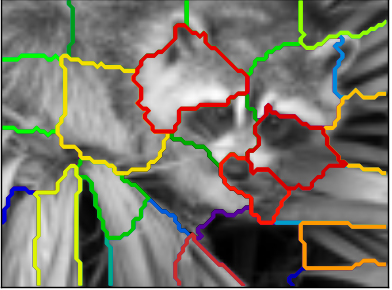

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации.

Проверим их на ```duck.jpg``` и ```owls.jpg```

### **Задание 5 (0.2 балла)**

Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [27]:
%%capture
!wget "https://raw.githubusercontent.com/Murcha1990/ML_AI24/refs/heads/main/Hometasks/Pro/Owls.jpg"
!wget "https://raw.githubusercontent.com/Murcha1990/ML_AI24/refs/heads/main/Hometasks/Pro/duck.jpg"

In [54]:
from PIL import Image

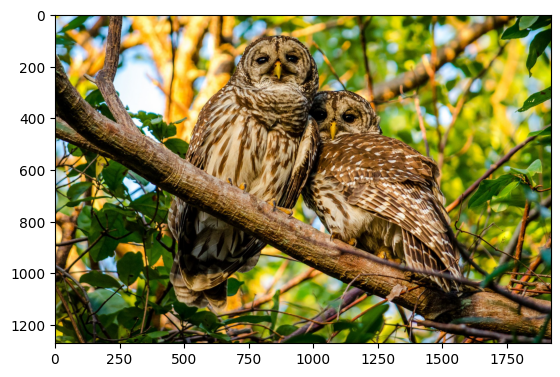

In [136]:
owls = Image.open('Owls.jpg')
plt.imshow(owls)

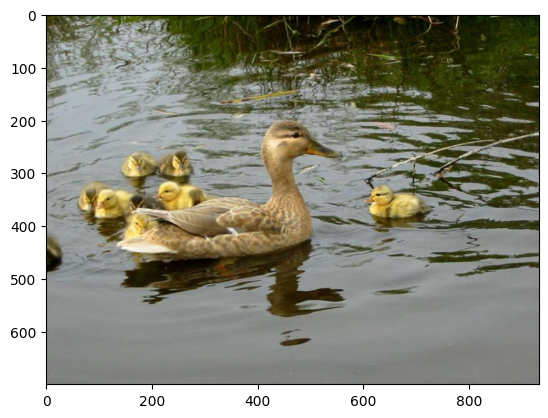

In [138]:
duck = Image.open('duck.jpg')
plt.imshow(duck)

### **Задание 6 (0.8 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

- Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :))
- Проанализируйте результат

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [144]:
from sklearn.cluster import KMeans

In [196]:
def find_components(image, lmbd, n_clusters):
    pic = np.array(image)
    xy_grid = np.array(
        np.meshgrid(
            np.arange(image.height),
            np.arange(image.width)
        )
    ).T.reshape(-1,2)
    objs = np.concatenate(
        (
            xy_grid * lmbd,
            pic[xy_grid[:, 0], xy_grid[:, 1]]
        ),
        axis=-1
    )

    kmeans = KMeans(n_clusters)
    classes = kmeans.fit_predict(objs)

    new_pic = np.zeros((image.height, image.width))
    new_pic[xy_grid[:, 0], xy_grid[:, 1]] = classes
    return new_pic, kmeans.score(objs)

#### Совушки

In [200]:
n_clusters_vals = []
pics = []
scores = []
for n_clusters in range(3, 15):
    pic, score = find_components(owls, 0.3, n_clusters)
    n_clusters_vals.append(n_clusters)
    pics.append(pic)
    scores.append(score)

Text(0.5, 0, 'n_clusters')

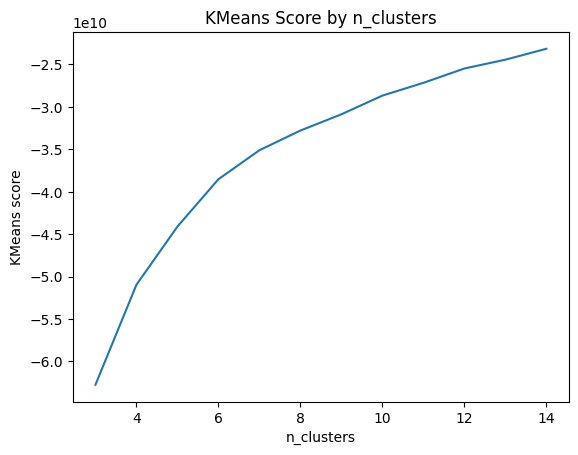

In [211]:
plt.plot(n_clusters_vals, scores)
plt.title('KMeans Score by n_clusters')
plt.ylabel('KMeans score')
plt.xlabel('n_clusters')

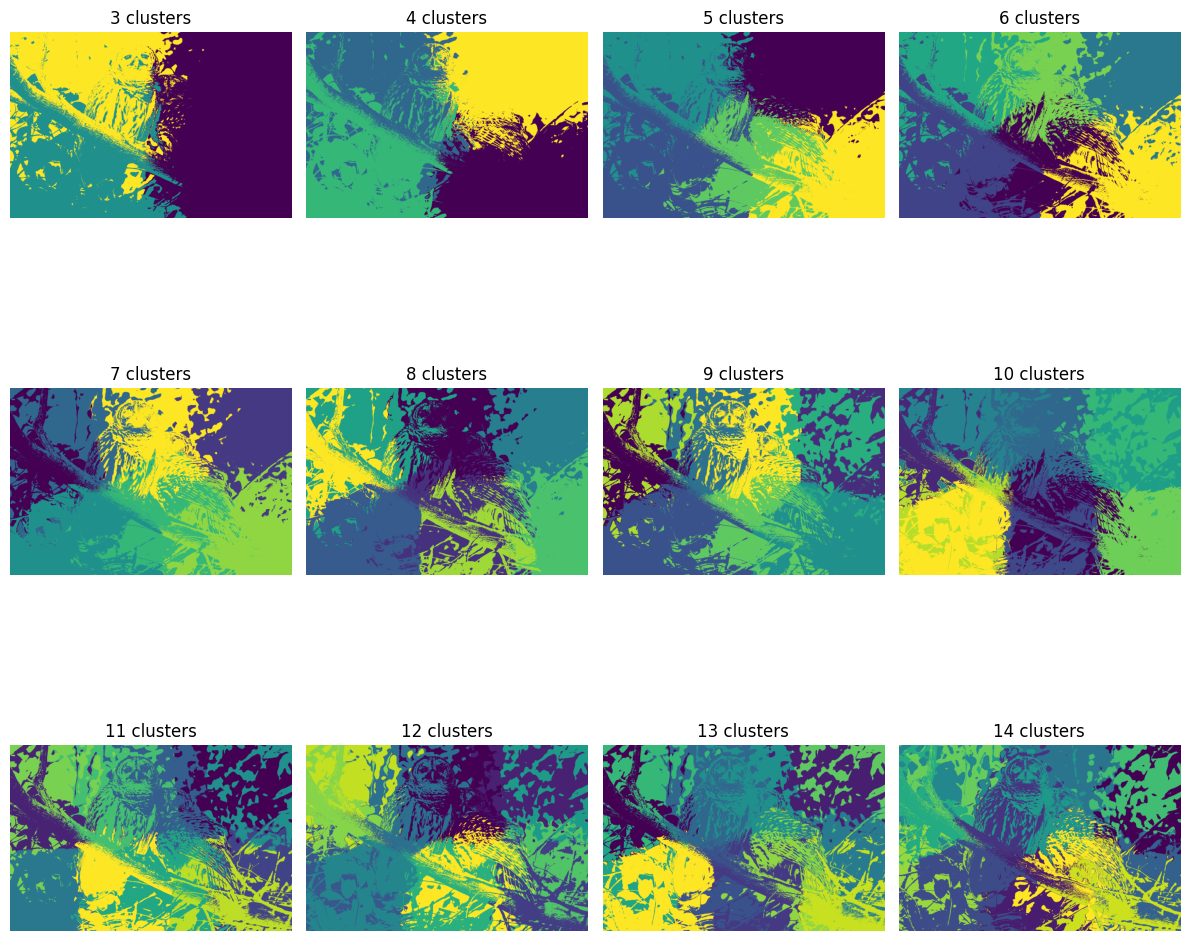

In [210]:
fig, plots = plt.subplots(3, 4, figsize=(12,12))
for i in range(12):
    plots[i//4][i%4].imshow(pics[i])
    plots[i//4][i%4].set_title(f'{n_clusters_vals[i]} clusters')
    plots[i//4][i%4].axis('off')
fig.tight_layout()
fig.show()

#### Утки

In [219]:
n_clusters_vals = []
pics = []
scores = []
for n_clusters in range(3, 15):
    pic, score = find_components(duck, 0.3, n_clusters)
    n_clusters_vals.append(n_clusters)
    pics.append(pic)
    scores.append(score)

Text(0.5, 0, 'n_clusters')

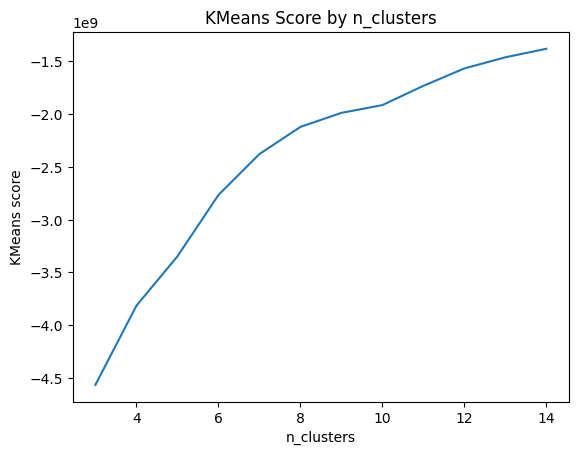

In [220]:
plt.plot(n_clusters_vals, scores)
plt.title('KMeans Score by n_clusters')
plt.ylabel('KMeans score')
plt.xlabel('n_clusters')

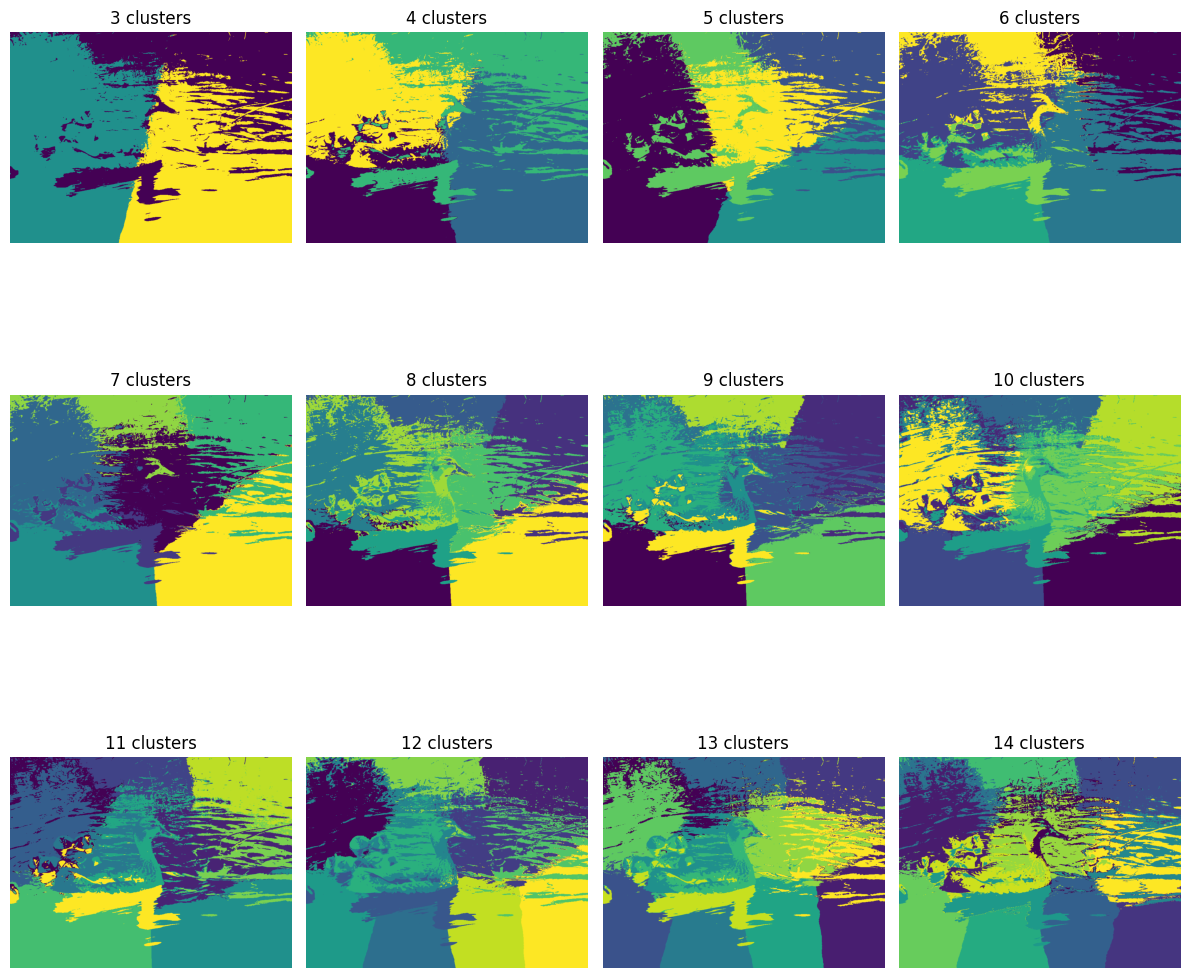

In [221]:
fig, plots = plt.subplots(3, 4, figsize=(12,12))
for i in range(12):
    plots[i//4][i%4].imshow(pics[i])
    plots[i//4][i%4].set_title(f'{n_clusters_vals[i]} clusters')
    plots[i//4][i%4].axis('off')
fig.tight_layout()
fig.show()

### **Задание 7 (0.8 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **Задание 8 (0.2 балла)**
- Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.
- Проанализируйте сравнение

In [ ]:
# Ваш код здесь

**Ваш ответ здесь**

### **Задание 9 (1 балл)**

- Найдите интересную картинку милого животного и примените алгоритмы и к ней. Поэкспериментируйте с параметрами алгоритмов и постарайтесь добиться оптимального результата. Картинку нужно будет загрузить вместе с работой.

- Сравните два подхода и сегментации, к которым они приводят. Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

**Примечание:**

Слишком большие лучше не брать - считаться будет долго. Не забудьте визуализировать!


In [ ]:
# Ваш код здесь

**Ваш ответ здесь**

## **Бонус (1 балл)**

В качестве бонуса предлагаем вам построить алгоритм кластеризации типов движения на наборе Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

### **Задание 1 (0.05 балла)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 2 (0.05 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 3 (0.15 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мспользуем методы **понижения размерности**. В частности, мы будем использовать метод главных компонент. Если вы проходили степик, то знакомы с ним, если нет, то почитать про PCA вам нужно в [Конспекте](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture12-factorizations.pdf).

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма массива pca.explained_variance_ratio_ должна быть больше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 4. (0.15 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 6 (0.05 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 7 (0.1 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш ответ здесь.**

### **Задание 8 (0.15 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш ответ здесь.**

### **Задание 9 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш ответ здесь.**

**Вы ещё здесь!** или **уже**?)

Спасибо за труд! Котобонус:

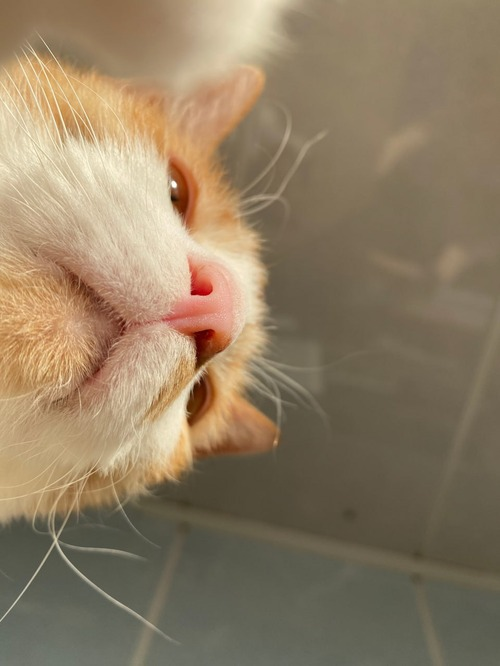